In [1]:
import numpy as np
import hoomd
import fresnel
import matplotlib.pyplot as plt
import scipy
import h5py
import gsd.hoomd
import itertools
import math
import time
import os
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
# This is not intended as a full tutorial on fresnel - see the
# fresnel user documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if ('version' not in dir(fresnel) or packaging.version.parse(
            fresnel.version.version) < FRESNEL_MIN_VERSION
            or packaging.version.parse(
                fresnel.version.version) >= FRESNEL_MAX_VERSION):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box
    
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(snapshot.particles.position),
                                       radius=0.5)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 192 / 255, 203 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L[0], L[1], L[2], 0, 0, 0], box_radius=.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.Orthographic(position=(L[0] * 2, L[1], L[2] * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L[2] * 1.4 + 1)
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [3]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=1)
simulation.create_state_from_gsd(filename='r3_T14_case_1_hot_spikeT09.gsd')

In [4]:
integrator = hoomd.md.Integrator(dt=1e-3) # was 1e-3 changed because higher temp means atoms have important interactions fast
cell = hoomd.md.nlist.Cell(buffer=0.2)
lj = hoomd.md.pair.LJ(nlist=cell) 
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 5.0
integrator.forces.append(lj)

In [5]:
#nvt --> nve
nve = hoomd.md.methods.ConstantVolume(
    filter=hoomd.filter.All())
integrator.methods.clear()  # Remove all existing methods
integrator.methods.append(nve)
simulation.operations.integrator = integrator

In [6]:
thermodynamic_properties = hoomd.md.compute.ThermodynamicQuantities(
    filter=hoomd.filter.All())

In [7]:
simulation.operations.computes.append(thermodynamic_properties)

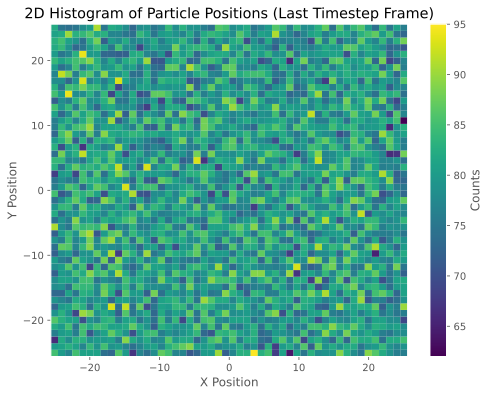

In [8]:
with gsd.hoomd.open('r3_T14_case_1_hot_spikeT09.gsd', 'r') as f:
    num_frames = len(f)
    last_frame = f[num_frames - 1]

positions = last_frame.particles.position[:, :2]  # get x, y

positions = np.array(positions)

plt.figure(figsize=(8, 6))
plt.hist2d(positions[:, 0], positions[:, 1], bins=50, cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D Histogram of Particle Positions (Last Timestep Frame)')
plt.show()


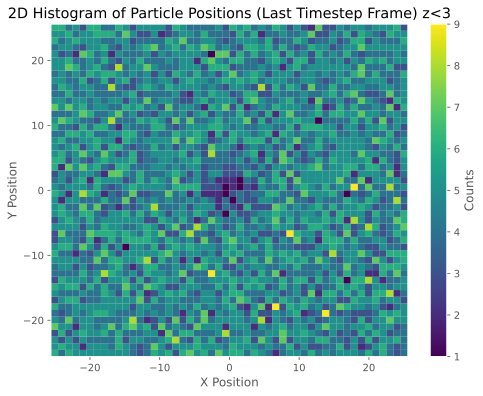

In [9]:
# last frame is at last time step
with gsd.hoomd.open('r3_T14_case_1_hot_spikeT09.gsd', 'r') as f:
    num_frames = len(f)
    last_frame = f[num_frames - 1]

positions = last_frame.particles.position[np.abs(last_frame.particles.position[:, 2]) < 3] # get x, y

positions = np.array(positions)

plt.figure(figsize=(8, 6))
plt.hist2d(positions[:, 0], positions[:, 1], bins=50, cmap='viridis')
plt.colorbar(label='Counts')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('2D Histogram of Particle Positions (Last Timestep Frame) z<3')
plt.show()

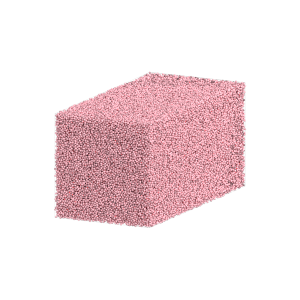

In [10]:
render(simulation.state.get_snapshot())

In [11]:
simulation.always_compute_pressure = False
simulation.run(1)
initial_temperature = thermodynamic_properties.kinetic_temperature

In [12]:
logger = hoomd.logging.Logger(categories=['scalar', 'sequence'])
logger.add(thermodynamic_properties)
logger.add(simulation, quantities=['timestep', 'walltime'])

if os.path.exists("r3_T14_longerT09.h5"):
    os.remove("r3_T14_longerT09.h5") # clear file if already created
    
hdf5_writer = hoomd.write.HDF5Log(trigger=hoomd.trigger.Periodic(10),
                                  filename='r3_T14_longerT09.h5',
                                  mode='w',
                                  logger=logger)
simulation.operations.writers.append(hdf5_writer)

In [13]:
simulation.run(1000)

In [14]:
simulation.operations.writers.remove(hdf5_writer)

In [15]:
thermodynamic_properties.kinetic_temperature

0.900745484732087

In [16]:
simulation.always_compute_pressure = True
simulation.run(1)
simulation.always_compute_pressure = False
thermodynamic_properties.pressure

0.03600586999230986

In [17]:
if os.path.exists("r3_T14_second_runT09.gsd"):
    os.remove("r3_T14_second_runT09.gsd") # clear file if already created
hoomd.write.GSD.write(state=simulation.state, filename='r3_T14_second_runT09.gsd', mode='xb')
# make gsds every 30 mins real time?

In [18]:
# total_simulation_time_hours = 2
# gsd_write_interval_minutes = 30
# gsd_write_interval_steps = int((gsd_write_interval_minutes * 60) / simulation.timestep)

# # Define the total simulation time in seconds
# total_simulation_time_seconds = total_simulation_time_hours * 3600

# start_time = time.time()
# current_time = start_time
# while current_time - start_time < total_simulation_time_seconds:
#     simulation.run(gsd_write_interval_steps)
#     filename = f'r3_100_{int(current_time - start_time)}.gsd'
#     hoomd.write.GSD.write(state=simulation.state, filename=filename, mode='xb')
#     current_time = time.time()
